In [157]:
# SikhiToTheMax/Khalis libraries
import banidb
from anvaad_py import firstLetters

import requests # to get raags
from sentence_transformers import SentenceTransformer, util # for embeddings
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Import for creating legend patches

In [2]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
# Supress Hugging Face's Symlinks warning. It wants to use Symlinks to save disk space
# But that requires you to turn on Windows developer mode, which comes with its own risks.

**Exploration**

In [3]:
shabad = banidb.random()

In [4]:
shabad

{'shabad_id': 3069,
 'source_uni': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
 'source_eng': 'Sri Guru Granth Sahib Ji',
 'writer': 'Guru Arjan Dev Ji',
 'ang': 816,
 'verses': [{'verse_id': 34703,
   'verse': 'ਬਿਲਾਵਲੁ ਮਹਲਾ ੫ ॥',
   'steek': {'en': {'bdb': 'Bilaaval, Fifth Mehla:',
     'ms': 'Bilawal 5th Guru.',
     'ssk': 'Bilaaval, Fifth Mehl:'},
    'pu': {'ss': {'gurmukhi': None, 'unicode': None},
     'ft': {'gurmukhi': '', 'unicode': ''},
     'bdb': {'gurmukhi': None, 'unicode': None},
     'ms': {'gurmukhi': 'iblwvl pMjvIN pwiqSwhI[',
      'unicode': 'ਬਿਲਾਵਲ ਪੰਜਵੀਂ ਪਾਤਿਸ਼ਾਹੀ।'}},
    'es': {'sn': 'Bilawal, Mejl Guru Aryan, Quinto Canal Divino'},
    'hi': {'ss': '', 'sts': 'बिलावलु महला ५ ॥'}},
   'transliteration': {'english': 'bilaaval mahalaa panjavaa ||',
    'hindi': 'बिलावलु महला ५ ॥',
    'en': 'bilaaval mahalaa panjavaa ||',
    'hi': 'बिलावलु महला ५ ॥',
    'ipa': 'bɪlɑʋəl məhəlɑ pəŋd͡ʒʋɑ.',
    'ur': 'بِلاول مهلا ۵ ۔۔'}},
  {'verse_id': 34704,
   'verse': 'ਸਿਮਰਿ ਸਿਮਰਿ ਪੂਰਨ ਪ੍ਰਭੂ ਕ

In [5]:
shabad.keys()

dict_keys(['shabad_id', 'source_uni', 'source_eng', 'writer', 'ang', 'verses'])

In [6]:
print(shabad['shabad_id'])

3069


In [7]:
print(shabad['source_uni'])

ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ


In [8]:
print(shabad['writer'])

Guru Arjan Dev Ji


In [9]:
print(shabad['ang'])

816


In [10]:
shabad['verses'][0]

{'verse_id': 34703,
 'verse': 'ਬਿਲਾਵਲੁ ਮਹਲਾ ੫ ॥',
 'steek': {'en': {'bdb': 'Bilaaval, Fifth Mehla:',
   'ms': 'Bilawal 5th Guru.',
   'ssk': 'Bilaaval, Fifth Mehl:'},
  'pu': {'ss': {'gurmukhi': None, 'unicode': None},
   'ft': {'gurmukhi': '', 'unicode': ''},
   'bdb': {'gurmukhi': None, 'unicode': None},
   'ms': {'gurmukhi': 'iblwvl pMjvIN pwiqSwhI[',
    'unicode': 'ਬਿਲਾਵਲ ਪੰਜਵੀਂ ਪਾਤਿਸ਼ਾਹੀ।'}},
  'es': {'sn': 'Bilawal, Mejl Guru Aryan, Quinto Canal Divino'},
  'hi': {'ss': '', 'sts': 'बिलावलु महला ५ ॥'}},
 'transliteration': {'english': 'bilaaval mahalaa panjavaa ||',
  'hindi': 'बिलावलु महला ५ ॥',
  'en': 'bilaaval mahalaa panjavaa ||',
  'hi': 'बिलावलु महला ५ ॥',
  'ipa': 'bɪlɑʋəl məhəlɑ pəŋd͡ʒʋɑ.',
  'ur': 'بِلاول مهلا ۵ ۔۔'}}

In [11]:
shabad['verses'][1] # starting verse of the shabad

{'verse_id': 34704,
 'verse': 'ਸਿਮਰਿ ਸਿਮਰਿ ਪੂਰਨ ਪ੍ਰਭੂ ਕਾਰਜ ਭਏ ਰਾਸਿ ॥',
 'steek': {'en': {'bdb': 'Meditate, meditate in remembrance of the Perfect Lord God, and your affairs shall be perfectly resolved.',
   'ms': 'Remembering and contemplating the Perfect Lord, mine affairs are all arranged.',
   'ssk': 'Meditate, meditate in remembrance of the Perfect Lord God, and your affairs shall be perfectly resolved.'},
  'pu': {'ss': {'gurmukhi': 'hy BweI! swD sMgiq ivc prmwqmw (Awp) v`sdw hY, Awpxy sMq jnW dy AMg-sMg v`sdw hY [ ',
    'unicode': 'ਹੇ ਭਾਈ! ਸਾਧ ਸੰਗਤਿ ਵਿਚ ਪਰਮਾਤਮਾ (ਆਪ) ਵੱਸਦਾ ਹੈ, ਆਪਣੇ ਸੰਤ ਜਨਾਂ ਦੇ ਅੰਗ-ਸੰਗ ਵੱਸਦਾ ਹੈ । '},
   'ft': {'gurmukhi': 'pUrn pRBU kO mn bwxI sy ismrn krny sy BgqoN ky srb kwrj rws hoey hYN]',
    'unicode': 'ਪੂਰਨ ਪ੍ਰਭੂ ਕੌ ਮਨ ਬਾਣੀ ਸੇ ਸਿਮਰਨ ਕਰਨੇ ਸੇ ਭਗਤੋਂ ਕੇ ਸਰਬ ਕਾਰਜ ਰਾਸ ਹੋਏ ਹੈਂ॥'},
   'bdb': {'gurmukhi': 'hy BweI! swD sMgiq ivc prmwqmw (Awp) v`sdw hY, Awpxy sMq jnW dy AMg-sMg v`sdw hY [ ',
    'unicode': 'ਹੇ ਭਾਈ! ਸਾਧ ਸੰਗਤਿ ਵਿਚ ਪਰਮਾਤਮਾ (ਆਪ) ਵੱਸਦਾ ਹੈ, ਆਪਣੇ ਸੰਤ ਜਨਾਂ ਦ

In [12]:
shabad['verses'][-1] # ending verse of the shabad

{'verse_id': 34713,
 'verse': 'ਜਪਿ ਨਾਨਕ ਨਾਮੁ ਨਿਧਾਨ ਸੁਖ ਪੂਰਾ ਗੁਰੁ ਪਾਇਆ ॥੪॥੩੩॥੬੩॥',
 'steek': {'en': {'bdb': 'Nanak chants the Naam, the Name of the Lord, the treasure of peace; I have found the Perfect Guru. ||4||33||63||',
   'ms': "Obtaining the Perfect Guru, Nanak utter the Lord's Name, the treasure of peace.",
   'ssk': 'Nanak chants the Naam, the Name of the Lord, the treasure of peace; I have found the Perfect Guru. ||4||33||63||'},
  'pu': {'ss': {'gurmukhi': ' hy nwnk! (swD sMgiq dI brkiq nwl) swry suKW dy ^zwny hir-nwm ƒ jp ky pUry gurU dw (sdw leI) imlwp pRwpq kr leIdw hY [4[33[63[',
    'unicode': ' ਹੇ ਨਾਨਕ! (ਸਾਧ ਸੰਗਤਿ ਦੀ ਬਰਕਤਿ ਨਾਲ) ਸਾਰੇ ਸੁਖਾਂ ਦੇ ਖ਼ਜ਼ਾਨੇ ਹਰਿ-ਨਾਮ ਨੂੰ ਜਪ ਕੇ ਪੂਰੇ ਗੁਰੂ ਦਾ (ਸਦਾ ਲਈ) ਮਿਲਾਪ ਪ੍ਰਾਪਤ ਕਰ ਲਈਦਾ ਹੈ ।੪।੩੩।੬੩।'},
   'ft': {'gurmukhi': 'sRI gurU jI khqy hYN: ijs ko pUrw gurU imilAw hY iqs ny nwm inDwn ko jp ky suK pwieAw hY]4]33]63]ÇvwihgurU kI AO sMqW kI mihmw aucwrn krqy hYN:',
    'unicode': 'ਸ੍ਰੀ ਗੁਰੂ ਜੀ ਕਹਤੇ ਹੈਂ: ਜਿਸ ਕੋ ਪੂਰਾ ਗੁਰੂ ਮਿਲਿਆ ਹੈ ਤਿਸ ਨੇ ਨਾਮ ਨਿਧਾਨ ਕ

**Searching a shabad**

In [13]:
gurbani_text = "ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ" # Thir ghar baiso har jan piaare

In [14]:
%%time
# Try searching 10 times across all sources, all angs, all angs, and all writers
# The default search options for banidb.search() are:
# banidb.search(query, searchtype=1, source='all', larivaar=False,
#              ang=None, raag=None, writer='all', page=1, results=None)
for i in range(10):
    ascii_query = firstLetters(gurbani_text)
    shabad_data = banidb.search(ascii_query)

CPU times: total: 188 ms
Wall time: 13.2 s


In [15]:
print(ascii_query)
shabad_data

ਥਘਬਹਜਪ


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

Now, let's find a shabad using a restricted search space

In [16]:
shabad_data['pages_data']['page_1'][0]

{'shabad_id': 628,
 'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
 'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
  'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
 'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
  'en': 'Sri Guru Granth Sahib Ji',
  'ang': 201,
  'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
  'raagen': 'Raag Gauree',
  'writer': 'Guru Arjan Dev Ji'}}

To restrict search space, the options in banidb.search are:
1. source
2. ang
3. raag
4. writer<br>
Let's try to extract these from shabad_data

*Source*

In [17]:
banidb.sources()

[{'source_id': 'A',
  'source_uni': 'ਅੰਮ੍ਰਿਤ ਕੀਰਤਨ',
  'source_eng': 'Amrit Keertan'},
 {'source_id': 'B',
  'source_uni': 'ਭਾਈ ਗੁਰਦਾਸ ਜੀ ਵਾਰਾਂ',
  'source_eng': 'Bhai Gurdas Ji Vaaran'},
 {'source_id': 'D', 'source_uni': 'ਦਸਮ ਬਾਣੀ', 'source_eng': 'Dasam Bani'},
 {'source_id': 'G',
  'source_uni': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
  'source_eng': 'Sri Guru Granth Sahib Ji'},
 {'source_id': 'N',
  'source_uni': 'ਭਾਈ ਨੰਦ ਲਾਲ ਜੀ ਵਾਰਾਂ',
  'source_eng': 'Bhai Nand Lal Ji Vaaran'},
 {'source_id': 'R',
  'source_uni': 'ਰਹਿਤਨਾਮੇ ਅਤੇ ਪੰਥਕ ਲਿਖ਼ਤਾਂ',
  'source_eng': 'Codes of Conduct and Other Panthic Sources'},
 {'source_id': 'S',
  'source_uni': 'ਭਾਈ ਗੁਰਦਾਸ ਸਿੰਘ ਜੀ ਵਾਰਾਂ',
  'source_eng': 'Bhai Gurdas Singh Ji Vaaran'}]

I think that the search space can be universally restricted to B (I don't know how this is different from S), D, G, N from https://banidbpy.readthedocs.io/en/latest/sources.html but it seems that the search function only allows for a string i.e. a single source instead of multiple ones: https://banidbpy.readthedocs.io/en/latest/searchdb.html

In [18]:
# banidb.search() accepts source ID, not the source in english or unicode (https://banidbpy.readthedocs.io/en/latest/sources.html)
# Map 'source_eng', which is what we get from banidb.search()'s output back to source ID so that we can use that in subsequent
# calls to banidb.search()
source_to_id_dict = {}
for item in banidb.sources():
    source_to_id_dict[item['source_eng']] = item['source_id']
source_to_id_dict

{'Amrit Keertan': 'A',
 'Bhai Gurdas Ji Vaaran': 'B',
 'Dasam Bani': 'D',
 'Sri Guru Granth Sahib Ji': 'G',
 'Bhai Nand Lal Ji Vaaran': 'N',
 'Codes of Conduct and Other Panthic Sources': 'R',
 'Bhai Gurdas Singh Ji Vaaran': 'S'}

In [19]:
# Extract source for the shabad
shabad_data['pages_data']['page_1'][0]['source']

{'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
 'en': 'Sri Guru Granth Sahib Ji',
 'ang': 201,
 'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
 'raagen': 'Raag Gauree',
 'writer': 'Guru Arjan Dev Ji'}

In [20]:
# Sanity check
shabad_source = shabad_data['pages_data']['page_1'][0]['source']['en']
print(shabad_source)
banidb.search(ascii_query, source = source_to_id_dict.get(shabad_source))

Sri Guru Granth Sahib Ji


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Ang*

In [21]:
shabad_ang = shabad_data['pages_data']['page_1'][0]['source']['ang']
print(shabad_ang)
# Sanity check
banidb.search(ascii_query, ang = shabad_ang)

201


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Raag*

In [22]:
try:
    raags = banidb.raags() # If this fails, try the one below
except:
    print("banidb.raags() doesn't work. Retrieving raags directly from the API")
    def get_raags_directly():
        """
        Fetches the list of raags directly from the BaniDB API,
        bypassing the banidb.raags() function.
        """
        # The API endpoint that the banidb library uses for raags
        url = "https://api.banidb.com/v2/raags"
        
        try:
            response = requests.get(url)
            # Raise an exception if the request returned an error (e.g., 404, 500)
            response.raise_for_status()
            
            # Convert the JSON response to a Python dictionary
            data = response.json()
            
            # The actual raag data is in the 'rows' key, skipping the header row
            raags_list = []
            for row in data['rows'][1:]:
                raag = {
                    'raag_id': row.get('RaagID'),
                    'raag_uni': row.get('RaagUnicode'),
                    'raag_eng': row.get('RaagEnglish')
                }
                raags_list.append(raag)
                
            return raags_list
    
        except requests.exceptions.RequestException as e:
            print(f"A network error occurred: {e}")
            return None
        except (KeyError, IndexError) as e:
            print(f"The API response format may have changed. Error: {e}")
            return None

        # --- Usage ---
    raags = get_raags_directly()
        
if raags:
    print("Successfully retrieved:")
    # Print the first 5 raags as an example
    for raag in raags:
        print(raag)

banidb.raags() doesn't work. Retrieving raags directly from the API
Successfully retrieved:
{'raag_id': 1, 'raag_uni': 'ਜਪ', 'raag_eng': 'Jap'}
{'raag_id': 2, 'raag_uni': 'ਸੋ ਦਰ', 'raag_eng': 'So Dar'}
{'raag_id': 3, 'raag_uni': 'ਸੋ ਪੁਰਖ', 'raag_eng': 'So Purakh'}
{'raag_id': 4, 'raag_uni': 'ਸੋਹਿਲਾ', 'raag_eng': 'Sohila'}
{'raag_id': 5, 'raag_uni': 'ਸਿਰੀ ਰਾਗੁ', 'raag_eng': 'Siree Raag'}
{'raag_id': 6, 'raag_uni': 'ਰਾਗੁ ਮਾਝ', 'raag_eng': 'Raag Maajh'}
{'raag_id': 7, 'raag_uni': 'ਰਾਗੁ ਗਉੜੀ', 'raag_eng': 'Raag Gauree'}
{'raag_id': 8, 'raag_uni': 'ਰਾਗੁ ਆਸਾ', 'raag_eng': 'Raag Aasaa'}
{'raag_id': 9, 'raag_uni': 'ਰਾਗੁ ਗੂਜਰੀ', 'raag_eng': 'Raag Gujri'}
{'raag_id': 10, 'raag_uni': 'ਰਾਗੁ ਦੇਵਗੰਧਾਰੀ', 'raag_eng': 'Raag Dayv Gandhaaree'}
{'raag_id': 11, 'raag_uni': 'ਰਾਗੁ ਬਿਹਾਗੜਾ', 'raag_eng': 'Raag Bihaagraa'}
{'raag_id': 12, 'raag_uni': 'ਰਾਗੁ ਵਡਹੰਸੁ', 'raag_eng': 'Raag Vadhans'}
{'raag_id': 13, 'raag_uni': 'ਰਾਗੁ ਸੋਰਠਿ', 'raag_eng': 'Raag Sorath'}
{'raag_id': 14, 'raag_uni': 'ਰਾਗੁ ਧਨਾਸਰੀ', 'raag_e

In [23]:
# banidb.search() accepts source ID, not the source in english or unicode (https://banidbpy.readthedocs.io/en/latest/sources.html)
# Map 'raag_eng', which is what we get from banidb.search()'s output back to 'raag_id' so that we can use that in subsequent
# calls to banidb.search()
raag_to_id_dict = {}
for item in raags: # or banidb.raags() if it doesn't fail
    raag_to_id_dict[item['raag_eng']] = item['raag_id']
raag_to_id_dict

{'Jap': 1,
 'So Dar': 2,
 'So Purakh': 3,
 'Sohila': 4,
 'Siree Raag': 5,
 'Raag Maajh': 6,
 'Raag Gauree': 7,
 'Raag Aasaa': 8,
 'Raag Gujri': 9,
 'Raag Dayv Gandhaaree': 10,
 'Raag Bihaagraa': 11,
 'Raag Vadhans': 12,
 'Raag Sorath': 13,
 'Raag Dhanaasree': 14,
 'Raag Jaithsree': 15,
 'Raag Todee': 16,
 'Raag Baihaaree': 17,
 'Raag Tilang': 18,
 'Raag Soohee': 19,
 'Raag Bilaaval': 20,
 'Raag Gond': 21,
 'Raag Raamkalee': 22,
 'Raag Nat Naaraayan': 23,
 'Raag Maalee Gauraa': 24,
 'Raag Maaroo': 25,
 'Raag Tukhaari': 26,
 'Raag Kaydaaraa': 27,
 'Raag Bhairao': 28,
 'Raag Basant': 29,
 'Raag Saarang': 30,
 'Raag Malaar': 31,
 'Raag Kaanraa': 32,
 'Raag Kalyaan': 33,
 'Raag Prabhaatee': 34,
 'Raag Jaijaavantee': 35,
 'Salok Sehskritee': 36,
 'Fifth Mehl, Gaathaa': 37,
 'Phunhay Fifth Mehl': 38,
 'Chaubolas Fifth Mehl': 39,
 'Salok Kabeer Jee': 40,
 'Salok Fareed Jee': 41,
 'Svaiyay Mehl 5': 42,
 'Salok Vaaraan Thay Vadheek': 43,
 'Salok Mehl 9': 44,
 'Mundhaavanee Fifth Mehl': 45,
 'Raa

In [24]:
shabad_raag = shabad_data['pages_data']['page_1'][0]['source']['raagen']
print(shabad_raag)
# Sanity check
banidb.search(ascii_query, raag = raag_to_id_dict.get(shabad_raag))

Raag Gauree


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Writer*

In [25]:
banidb.writers()

[{'writer_id': 1, 'writer_name': 'Guru Nanak Dev Ji'},
 {'writer_id': 2, 'writer_name': 'Guru Angad Dev Ji'},
 {'writer_id': 3, 'writer_name': 'Guru Amar Daas Ji'},
 {'writer_id': 4, 'writer_name': 'Guru Raam Daas Ji'},
 {'writer_id': 5, 'writer_name': 'Guru Arjan Dev Ji'},
 {'writer_id': 6, 'writer_name': 'Guru Tegh Bahaadur Ji'},
 {'writer_id': 7, 'writer_name': 'Bhagat Bheekhan Ji'},
 {'writer_id': 8, 'writer_name': 'Bhagat Beni Ji'},
 {'writer_id': 9, 'writer_name': 'Bhagat Dhannaa Ji'},
 {'writer_id': 10, 'writer_name': 'Bhagat Trilochan Ji'},
 {'writer_id': 11, 'writer_name': 'Bhagat Jaidev Ji'},
 {'writer_id': 12, 'writer_name': 'Bhagat Kabeer Ji'},
 {'writer_id': 13, 'writer_name': 'Bhagat Naam Dev Ji'},
 {'writer_id': 14, 'writer_name': 'Bhagat Peepaa Ji'},
 {'writer_id': 15, 'writer_name': 'Bhagat Parmaanand Ji'},
 {'writer_id': 16, 'writer_name': 'Bhagat Ravi Daas Ji'},
 {'writer_id': 17, 'writer_name': 'Bhagat Raamaanand Ji'},
 {'writer_id': 18, 'writer_name': 'Bhagat Surda

In [26]:
# banidb.search() accepts writer ID, not the writer name or unicode (https://banidbpy.readthedocs.io/en/latest/writers.html)
# Map 'writer_name', which is what we get from banidb.search()'s output back to 'writer_id' so that we can use that in subsequent
# calls to banidb.search()
writer_to_id_dict = {}
for item in banidb.writers():
    writer_to_id_dict[item['writer_name']] = item['writer_id']
writer_to_id_dict

{'Guru Nanak Dev Ji': 1,
 'Guru Angad Dev Ji': 2,
 'Guru Amar Daas Ji': 3,
 'Guru Raam Daas Ji': 4,
 'Guru Arjan Dev Ji': 5,
 'Guru Tegh Bahaadur Ji': 6,
 'Bhagat Bheekhan Ji': 7,
 'Bhagat Beni Ji': 8,
 'Bhagat Dhannaa Ji': 9,
 'Bhagat Trilochan Ji': 10,
 'Bhagat Jaidev Ji': 11,
 'Bhagat Kabeer Ji': 12,
 'Bhagat Naam Dev Ji': 13,
 'Bhagat Peepaa Ji': 14,
 'Bhagat Parmaanand Ji': 15,
 'Bhagat Ravi Daas Ji': 16,
 'Bhagat Raamaanand Ji': 17,
 'Bhagat Surdaas Ji': 18,
 'Bhagat Saadhnaa Ji': 19,
 'Bhagat Sain Ji': 20,
 'Bhagat Sheikh Fareed Ji': 21,
 'Bhai Gurdaas Ji': 22,
 'Bhatt Bal': 30,
 'Bhatt Sathaa & Balvand': 31,
 'Bhatt (Baba) Sundar': 32,
 'Bhatt Gayandh': 33,
 'Bhatt Harbans': 34,
 'Bhatt Bhikhaa': 35,
 'Bhatt Jal Jaalap': 37,
 'Bhatt Keerath ': 38,
 'Bhatt Kal': 41,
 'Bhatt Kall Sahaar': 40,
 'Bhatt Mathuraa': 42,
 'Bhai Mardana': 43,
 'Bhatt Nal': 44,
 'Bhatt Sal': 45,
 'Bhatt Tal': 46,
 'Guru Gobind Singh Ji': 47,
 'Bhai Nand Lal Ji': 48,
 'Bhai Gurdas Singh Ji': 49,
 'Bhai Da

In [27]:
shabad_writer = shabad_data['pages_data']['page_1'][0]['source']['writer']
print(shabad_writer)
# Sanity check
banidb.search(ascii_query, writer = writer_to_id_dict.get(shabad_writer))

Guru Arjan Dev Ji


{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

*Checking speed for restricted space search*

In [28]:
shabad_source_id = source_to_id_dict.get(shabad_source)
shabad_raag_id   = raag_to_id_dict.get(shabad_raag)
shabad_writer_id = writer_to_id_dict.get(shabad_writer)

In [29]:
%%time
for i in range(10):
    ascii_query = firstLetters(gurbani_text)
    shabad_data = banidb.search(ascii_query, source=shabad_source_id, ang=shabad_ang, raag=shabad_raag_id, writer=shabad_writer_id)

CPU times: total: 203 ms
Wall time: 13.2 s


In [30]:
banidb.search(ascii_query, source=shabad_source_id, ang=shabad_ang, raag=shabad_raag_id, writer=shabad_writer_id)

{'total_results': 1,
 'total_pages': 1,
 'pages_data': {'page_1': [{'shabad_id': 628,
    'verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥',
    'steek': {'en': 'Remain steady in the home of your own self, O beloved servant of the Lord.',
     'pu': 'ਹੇ ਪਿਆਰੇ ਭਗਤ ਜਨੋ! ਆਪਣੇ ਹਿਰਦੇ ਵਿਚ ਇਹ ਪੂਰੀ ਸਰਧਾ ਬਣਾਓ'},
    'source': {'pu': 'ਸ੍ਰੀ ਗੁਰੂ ਗ੍ਰੰਥ ਸਾਹਿਬ ਜੀ',
     'en': 'Sri Guru Granth Sahib Ji',
     'ang': 201,
     'raagpu': 'ਰਾਗੁ ਗਉੜੀ',
     'raagen': 'Raag Gauree',
     'writer': 'Guru Arjan Dev Ji'}}]}}

In [31]:
shabad_source

'Sri Guru Granth Sahib Ji'

Wow. Seems like this didn't help at all. Also, while it is good to see how to improve the tuk/line retrieval time, at the end of the day, we don't even know if we can get ASR correct. If the ASR is incorrect, then the first letters would be incorrect too, and doing a banidb.search() would be futile no matter how optimized it is. So, a better approach is to take the ASR output and convert that into an embedding that can then be compared against the verses of the shabad. To do so, we first need to get all the verses of the shabad.

**Shabad verses and embeddings**

It is great that we can identify a shabad from across all Sikh scriptures. 
1. We have also found that restricting the search space in banidb.search() doesn't seem to improve the time required to identify.
2. In addition, banidb would require us to have the correct search query to find a shabad. Since we will rely on ASR for getting the text for the gurbani tuk/line, we can't be certain of that. <br>

So, we need to find a new method. Here is the proposed approach:
1. Identify the shabad by using banidb search via skip-gram approach. That is, take the whole text sequence and split it into multiple parts. Then, pass this into banidb.search(). If the text sequence's first letters using ASR turn out to be "tgvhjp" ("thir ghar baiso har jan piaare"), where "baiso" is incorrectly identified as "vaiso", then we can pass multiple queries by splitting - "tgvhjp", "gvhj", "tvhj", "vhjp" etc. The return from these queries can be used to identify shabad IDs. The median of these results can be picked as the relevant shabad. We can also store other results in memory in case the search query fails in the future.
2. Once the shabad is identified, we will get all its verses using banidb.shabad(). Then, we will no longer use the skip-gram approach for subsequent searches. Instead, we will use the more powerful method of embeddings. We will embed the ASR output as embeddings and compare them to the embeddings of the verses for that shabad. This search space should be quite small and we hope to be able to identify the verse fairly quickly.
3. We need to continuously monitor the words being sung and ensure that the verse/tuk identified is same as the previous one. If it changes (with high confidence), we need to switch to giving a new verse as the output.

In [32]:
import re

In [33]:
def clean_gurbani_verse(text):
    """
    Removes verse numbers, punctuation, and the word 'Rahaao' from a Gurbani line.
    This is needed because in ASR, we will never get these in the output as no raagi
    sings these.
    """
    # Remove numbers (both Gurmukhi and Arabic)
    text = re.sub(r'[\u0A66-\u0A6F0-9]+', '', text)
    # Remove the word 'Rahaao' (ਰਹਾਉ)
    text = text.replace('ਰਹਾਉ', '')
    # Remove Danda (॥), Visarg (ਃ), and other common punctuation
    text = re.sub(r'[॥।☬ਃ|]', '', text)
    # Remove extra spaces and strip whitespace from ends
    text = ' '.join(text.split())
    return text

In [34]:
# Sanity check
shabad_id = shabad_data['pages_data']['page_1'][0]['shabad_id']
shabad_data2 = banidb.shabad(shabad_id)
[(clean_gurbani_verse(item['verse']), item['verse']) for item in shabad_data2['verses']]

[('ਗਉੜੀ ਮਹਲਾ', 'ਗਉੜੀ ਮਹਲਾ ੫ ॥'),
 ('ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ ॥'),
 ('ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ ॥੧॥ ਰਹਾਉ ॥'),
 ('ਦੁਸਟ ਦੂਤ ਪਰਮੇਸਰਿ ਮਾਰੇ', 'ਦੁਸਟ ਦੂਤ ਪਰਮੇਸਰਿ ਮਾਰੇ ॥'),
 ('ਜਨ ਕੀ ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ', 'ਜਨ ਕੀ ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ ॥੧॥'),
 ('ਬਾਦਿਸਾਹ ਸਾਹ ਸਭ ਵਸਿ ਕਰਿ ਦੀਨੇ', 'ਬਾਦਿਸਾਹ ਸਾਹ ਸਭ ਵਸਿ ਕਰਿ ਦੀਨੇ ॥'),
 ('ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ ਰਸ ਪੀਨੇ', 'ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ ਰਸ ਪੀਨੇ ॥੨॥'),
 ('ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ', 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ ॥'),
 ('ਸਾਧਸੰਗਤਿ ਮਿਲਿ ਕੀਨੋ ਦਾਨੁ', 'ਸਾਧਸੰਗਤਿ ਮਿਲਿ ਕੀਨੋ ਦਾਨੁ ॥੩॥'),
 ('ਸਰਣਿ ਪਰੇ ਪ੍ਰਭ ਅੰਤਰਜਾਮੀ', 'ਸਰਣਿ ਪਰੇ ਪ੍ਰਭ ਅੰਤਰਜਾਮੀ ॥'),
 ('ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ', 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ ॥੪॥੧੦੮॥')]

In [41]:
# --- Step 1: Initialization (Done once) ---
# Load a pre-trained model suitable for multilingual text including Gurmukhi
model = SentenceTransformer('bert-base-multilingual-cased')
# from transformers import AutoModel, AutoTokenizer
# from sentence_transformers import SentenceTransformer, models

# # Step 1: Load components manually
# word_embedding_model = models.Transformer('bert-base-multilingual-cased', max_seq_length=128)
# pooling_model = models.Pooling(
#     word_embedding_model.get_word_embedding_dimension(),
#     pooling_mode_mean_tokens=True,
#     pooling_mode_cls_token=True, # False for large phrases (> 3 words)
#     pooling_mode_max_tokens=False
# )

# Step 2: Wrap them into a SentenceTransformer object
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# --- Step 2: Get Shabad and Pre-compute Embeddings ---
all_verses_text = [clean_gurbani_verse(item['verse']) for item in shabad_data2['verses']]

# Pre-compute the embeddings for every line in the shabad (very fast)
shabad_embeddings = model.encode(all_verses_text, convert_to_tensor=True)

# --- Step 3: Match a Subsequent Line ---
# Imagine this is the new, possibly flawed output from your ASR
asr_output_phrase = "ਸਤਗੁਰ" # Example phrase, imperfectly converted from text to speech
# asr_output_phrase = "ਸਤਗੁਰ ਤੁਮਰੇ ਕਜ ਸਵਾਰ" # Example phrase, imperfectly converted from text to speech

# Encode the ASR phrase into a vector
asr_embedding = model.encode(asr_output_phrase, convert_to_tensor=True)

# Compute cosine similarity between the ASR phrase and all lines in the shabad
cosine_scores = util.cos_sim(asr_embedding, shabad_embeddings)

# Find the line with the highest score
best_match_index = cosine_scores.argmax()
best_match_verse = all_verses_text[best_match_index]
best_match_score = cosine_scores[0][best_match_index]

print(f"Best match found: '{best_match_verse}'")
print(f"Similarity score: {best_match_score:.4f}")

No sentence-transformers model found with name bert-base-multilingual-cased. Creating a new one with mean pooling.


Best match found: 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ'
Similarity score: 0.8482


In [42]:
# --- Step 1: Initialization (Done once) ---
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load ai4bharat model and slow tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert", use_fast=False)
model = AutoModel.from_pretrained("ai4bharat/indic-bert")

def encode(texts):
    if isinstance(texts, str):
        texts = [texts]
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0]  # CLS token
    return F.normalize(cls_embeddings, p=2, dim=1)


# --- Step 2: Get Shabad and Pre-compute Embeddings ---
all_verses_text = [clean_gurbani_verse(item['verse']) for item in shabad_data2['verses']]
shabad_embeddings = encode(all_verses_text)

# --- Step 3: Match a Subsequent Line ---
asr_output_phrase = "ਸਤਗੁਰ"  # Example phrase from ASR
asr_embedding = encode(asr_output_phrase)

# Compute cosine similarity between the ASR phrase and all lines in the shabad
cosine_scores = torch.nn.functional.cosine_similarity(asr_embedding, shabad_embeddings)

# Find the line with the highest score
best_match_index = cosine_scores.argmax()
best_match_verse = all_verses_text[best_match_index]
best_match_score = cosine_scores[best_match_index]

print(f"Best match found: '{best_match_verse}'")
print(f"Similarity score: {best_match_score:.4f}")


Best match found: 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ'
Similarity score: 0.9976


Using sentence-transformers/distiluse-base-multilingual-cased-v2 gives poor results. Same with ai4bharat/indic-bert' but that's because it is not a sentence transformer.

In [63]:
from sentence_transformers import SentenceTransformer, util, models
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

class ShabadMatcher:
    def __init__(self, model_name: str, pooling: str = 'cls', use_cls: bool = False):
        self.model_name = model_name
        self.pooling = pooling
        self.use_cls = use_cls

        if model_name == "ai4bharat/indic-bert":
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
            self.model = AutoModel.from_pretrained(model_name)
            self.encode_fn = self._encode_indic_bert

        elif model_name == "bert-base-multilingual-cased":
            word_embedding_model = models.Transformer(model_name, max_seq_length=128)
            pooling_model = models.Pooling(
                word_embedding_model.get_word_embedding_dimension(),
                pooling_mode_mean_tokens=(pooling == 'mean'),
                pooling_mode_cls_token=(pooling == 'cls'),
                pooling_mode_max_tokens=False
            )
            self.model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
            self.encode_fn = self._encode_sbert

        elif model_name in [
            "l3cube-pune/indic-sentence-similarity-sbert",
            "sentence-transformers/LaBSE",
            "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
        ]:
            self.model = SentenceTransformer(model_name)
            self.encode_fn = self._encode_sbert

        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def _encode_sbert(self, texts):
        return self.model.encode(texts, convert_to_tensor=True)

    def _encode_indic_bert(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        inputs = self.tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
        if self.use_cls:
            embeddings = outputs.last_hidden_state[:, 0]
        else:
            mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size())
            masked_embeddings = outputs.last_hidden_state * mask
            summed = masked_embeddings.sum(dim=1)
            counts = mask.sum(dim=1)
            embeddings = summed / counts
        return F.normalize(embeddings, p=2, dim=1)

    def match(self, shabad_data, asr_output_phrase, min_words=3):
        if len(asr_output_phrase.strip().split()) < min_words:
            print(f"[Skipping] Phrase too short (min_words={min_words}): '{asr_output_phrase}'")
            return None
            
        verses = [clean_gurbani_verse(item['verse']) for item in shabad_data['verses']]
        shabad_embeddings = self.encode_fn(verses)
        asr_embedding = self.encode_fn(asr_output_phrase)

        if isinstance(shabad_embeddings, torch.Tensor):
            scores = F.cosine_similarity(asr_embedding, shabad_embeddings)
            best_idx = scores.argmax()
            best_score = scores[best_idx]
        else:
            scores = util.cos_sim(asr_embedding, shabad_embeddings)
            best_idx = scores.argmax()
            best_score = scores[0][best_idx]

        return {
            'best_verse': verses[best_idx],
            'score': round(float(best_score), 2),
            'index': int(best_idx)
        }

In [85]:
models_to_test = {
    "BBMC": ShabadMatcher("bert-base-multilingual-cased", pooling="cls"),
    "L3Cube": ShabadMatcher("l3cube-pune/indic-sentence-similarity-sbert"),
    "LaBSE": ShabadMatcher("sentence-transformers/LaBSE"),
    "MiniLM": ShabadMatcher("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"),
    "IndicBERT (CLS)": ShabadMatcher("ai4bharat/indic-bert", use_cls=True),
    "IndicBERT (Mean)": ShabadMatcher("ai4bharat/indic-bert", use_cls=False)
}

In [158]:
def test_phrases(asr_phrases, correct_indices):
    results_verse =  {key:[] for key in models_to_test.keys()}
    results_status =  {key:[] for key in models_to_test.keys()}
    results_score =  {key:[] for key in models_to_test.keys()}
    assert(len(asr_phrases) == len(correct_indices))
    for i, phrase in enumerate(asr_phrases):
        print(f"\n------For {phrase}------")
        for name, matcher in models_to_test.items():
            result = matcher.match(shabad_data2, phrase)
            status = False if result is None else int(result['index'] == correct_indices[i])
            results_status[name].append(status)
            verse = None if result is None else result['best_verse']
            results_verse[name].append(verse)
            score = None if result is None else result['score']
            results_score[name].append(score)
            print(f"{name}: {result}. Correct? {bool(status) if status is not None else status}")
    return results_status, results_verse, results_score

In [156]:
def plot_similarity_by_status(models_to_test, statuses, scores):
    """
    Creates a 3x2 grid of bar plots showing similarity scores,
    grouped and sorted by status, with a clear legend.
    """
    fig, axs = plt.subplots(3, 2, figsize=(15, 13))
    axs = axs.flatten()

    for i, model in enumerate(models_to_test):
        status_list = statuses.get(model, [])
        score_list = scores.get(model, [])

        # Separate data by status
        status_1_data = sorted(
            [(score_list[j], f'Inst {j}') for j, s in enumerate(status_list) if s == 1],
            key=lambda x: x[0], reverse=True
        )
        status_0_data = sorted(
            [(score_list[j], f'Inst {j}') for j, s in enumerate(status_list) if s == 0],
            key=lambda x: x[0], reverse=True
        )
        
        # Unzip sorted data, handling cases where a status might be missing
        scores_1, labels_1 = zip(*status_1_data) if status_1_data else ([], [])
        scores_0, labels_0 = zip(*status_0_data) if status_0_data else ([], [])

        # Combine for plotting
        combined_scores = list(scores_1) + list(scores_0)
        combined_labels = list(labels_1) + list(labels_0)
        combined_colors = ['tab:blue'] * len(scores_1) + ['tab:orange'] * len(scores_0)
        
        ax = axs[i]
        if combined_scores:
            ax.bar(range(len(combined_scores)), combined_scores, color=combined_colors)
        
        ax.set_title(model)
        ax.set_xlabel('Instance')
        ax.set_ylabel('Similarity Score')
        ax.set_ylim(np.min(combined_scores)-0.01, np.max(combined_scores)+0.01)
        ax.set_xticks(range(len(combined_labels)))
        ax.set_xticklabels(combined_labels, rotation=45, ha='right')

    # Create legend handles and add them to the figure just once
    legend_patch_1 = mpatches.Patch(color='tab:blue', label='Status 1 (True)')
    legend_patch_0 = mpatches.Patch(color='tab:orange', label='Status 0 (False)')
    fig.legend(handles=[legend_patch_1, legend_patch_0], loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for the legend
    plt.show()

In [115]:
short_asr_phrases = [
    'ਦੁਸਟ', 'ਦੁਸ਼ਟ', 'ਦੁਸਟ ਦੂਤ', 'ਕਰ ਦੀਨੇ', 'ਕਰਤਾਰੇ', 'ਕੀਨੋ ਦਾਨ',
    'ਦਾਨ', 'ਨਿਰਭੌ', 'ਸਾਧ ਸੰਗ', 'ਸਾਧ', 'ਅੰਤਰ', 'ਜਾਮੀ', 'ਪਕੜੀ ਪ੍ਰਭ'
]
short_asr_correct = [3, 3, 3, 5, 4, 8,
                     8, 7, 8, 8, 9, 9, 10]
statuses, verses, scores = test_phrases(short_asr_phrases, short_asr_correct)


------For ਦੁਸਟ------
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
BBMC: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
L3Cube: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
LaBSE: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
MiniLM: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
IndicBERT (CLS): None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸਟ'
IndicBERT (Mean): None. Correct? False

------For ਦੁਸ਼ਟ------
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
BBMC: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
L3Cube: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
LaBSE: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
MiniLM: None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
IndicBERT (CLS): None. Correct? False
[Skipping] Phrase too short (min_words=3): 'ਦੁਸ਼ਟ'
IndicBER

In [160]:
# 3 word phrases, all beginning and ending within the same verse (ideal use case)
long_asr_phrases = [
    'ਸਤਗੁਰ ਤੁਮਰੇ ਕਾਜ', 'ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'ਦੁਸ਼ਟ ਦੂਤ ਪਰਮੇਸਰ', 'ਦੂਤ ਪਰਮੇਸਰ ਮਾਰੇ', 'ਜਨ ਕੀ ਪੈਜ', 'ਕੀ ਪੈਜ ਰਖੀ', 'ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ',
    'ਨਿਰਭੌ ਹੋ ਭਜੋ', 'ਹੋ ਭਜੋ ਭਗਵਾਨ', 'ਹੋ ਭਜੋ ਪਗਵਾਨ', 'ਬਾਦ ਸ਼ਾਹ ਸ਼ਾਹ', 'ਸ਼ਾਹ ਸ਼ਾਹ ਸਬ', 'ਵੱਸ ਕਰ ਦੀਨੇ', 'ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ']
long_asr_correct = [2, 2, 3, 3, 4, 4, 4,
                       7, 7, 7, 5, 5, 5, 6]
    
statuses, verses, scores = test_phrases(long_asr_phrases, long_asr_correct)


------For ਸਤਗੁਰ ਤੁਮਰੇ ਕਾਜ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.98, 'index': 2}. Correct? True
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.86, 'index': 2}. Correct? True
LaBSE: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.76, 'index': 2}. Correct? True
MiniLM: {'best_verse': 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ', 'score': 0.95, 'index': 7}. Correct? False
IndicBERT (CLS): {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 1.0, 'index': 2}. Correct? True
IndicBERT (Mean): {'best_verse': 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ', 'score': 0.82, 'index': 7}. Correct? False

------For ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.98, 'index': 2}. Correct? True
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.78, 'index': 2}. Correct? True
LaBSE: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.62, 'index': 2}. Correct? True
MiniLM: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.88, 'index': 2}. Correct? True
IndicB

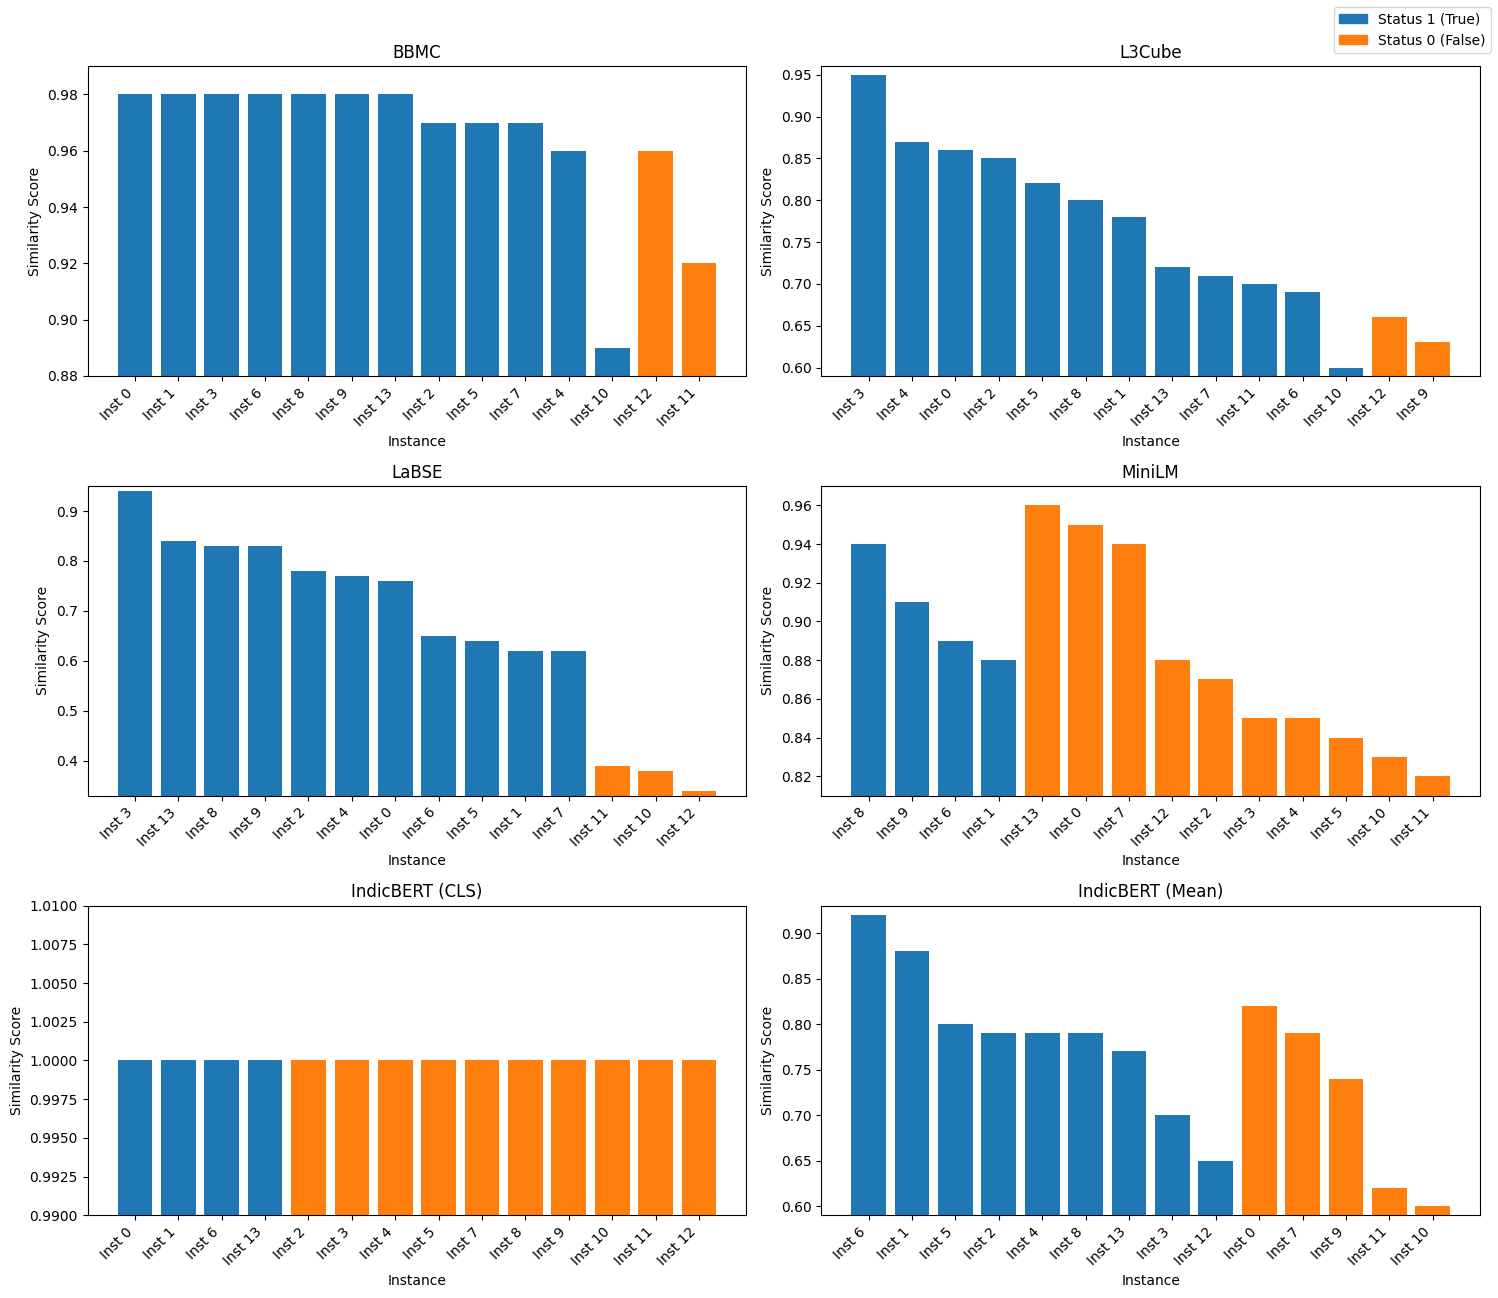

In [159]:
plot_similarity_by_status(models_to_test, statuses, scores)

In [ ]:
0 'ਗਉੜੀ ਮਹਲਾ',
1 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ',
2 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ',
3 'ਦੁਸਟ ਦੂਤ ਪਰਮੇਸਰਿ ਮਾਰੇ',
4 'ਜਨ ਕੀ ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ',
5 'ਬਾਦਿਸਾਹ ਸਾਹ ਸਭ ਵਸਿ ਕਰਿ ਦੀਨੇ',
6 'ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ ਰਸ ਪੀਨੇ',
7 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ',
8 'ਸਾਧਸੰਗਤਿ ਮਿਲਿ ਕੀਨੋ ਦਾਨੁ',
9 'ਸਰਣਿ ਪਰੇ ਪ੍ਰਭ ਅੰਤਰਜਾਮੀ',
10 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ'

In [161]:
# 3 word phrases, beginning in one verse and ending in another (edge case)
mixed_asr_phrases = [
    'ਜਨ ਪਿਆਰੇ ਸਤਗੁਰ', 'ਪਿਆਰੇ ਸਤਗੁਰ ਤੁਮਰੇ', 'ਕਾਜ ਸਵਾਰੇ ਦੁਸ਼ਟ', 'ਸਵਾਰੇ ਦੁਸ਼ਟ ਦੂਤ', 'ਪਰਮੇਸਰ ਮਾਰੇ ਜਨ', 
    'ਮਾਰੇ ਜਨ ਕੀ',  'ਰਖੀ ਕਰਤਾਰੇ ਬਾਦ', 'ਪੀਨੇ ਨਿਰਭੌ ਹੋ', 'ਭਜੋ ਪਗਵਾਨ ਸਾਧ', 'ਕੀਨੋ ਦਾਨ ਸਰਣ', 'ਦਾਨ ਸਰਣ ਪਰੇ', 'ਦਾਨ ਸਰਣ ਭਰੇ']
# detect the correct phrase/index as the one with the dominant number of words
mixed_asr_correct = [1, 2, 2, 3, 3, 
                     4, 4, 7, 7, 8, 9, 9]
statuses, verses, scores = test_phrases(mixed_asr_phrases, mixed_asr_correct)


------For ਜਨ ਪਿਆਰੇ ਸਤਗੁਰ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.97, 'index': 2}. Correct? False
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.75, 'index': 2}. Correct? False
LaBSE: {'best_verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'score': 0.62, 'index': 1}. Correct? True
MiniLM: {'best_verse': 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ', 'score': 0.89, 'index': 10}. Correct? False
IndicBERT (CLS): {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 1.0, 'index': 2}. Correct? False
IndicBERT (Mean): {'best_verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'score': 0.75, 'index': 1}. Correct? True

------For ਪਿਆਰੇ ਸਤਗੁਰ ਤੁਮਰੇ------
BBMC: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.97, 'index': 2}. Correct? True
L3Cube: {'best_verse': 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ', 'score': 0.77, 'index': 2}. Correct? True
LaBSE: {'best_verse': 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ', 'score': 0.56, 'index': 1}. Correct? False
MiniLM: {'best_verse': 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ', 'score': 0.93, 'index': 1

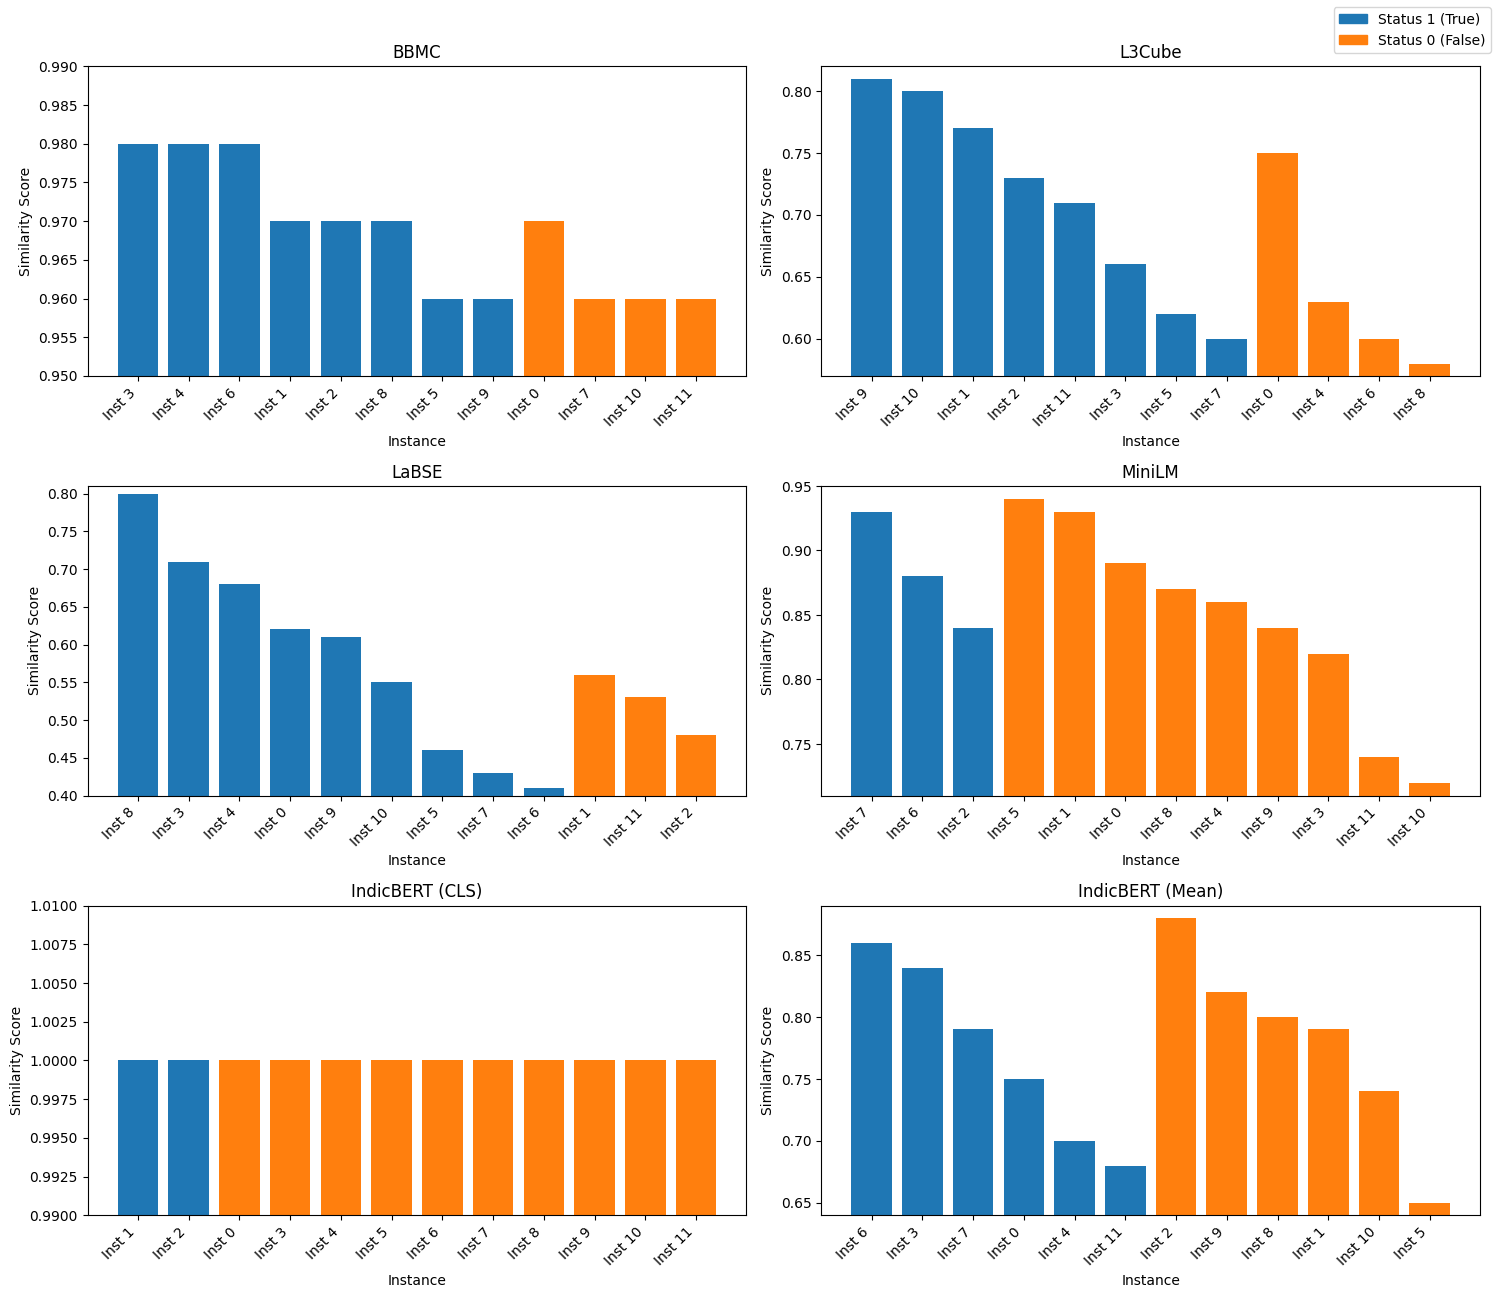

In [162]:
plot_similarity_by_status(models_to_test, statuses, scores)

In [67]:
shabad_data['pages_data']['page_1'][0]['shabad_id']

['ਗਉੜੀ ਮਹਲਾ',
 'ਥਿਰੁ ਘਰਿ ਬੈਸਹੁ ਹਰਿ ਜਨ ਪਿਆਰੇ',
 'ਸਤਿਗੁਰਿ ਤੁਮਰੇ ਕਾਜ ਸਵਾਰੇ',
 'ਦੁਸਟ ਦੂਤ ਪਰਮੇਸਰਿ ਮਾਰੇ',
 'ਜਨ ਕੀ ਪੈਜ ਰਖੀ ਕਰਤਾਰੇ',
 'ਬਾਦਿਸਾਹ ਸਾਹ ਸਭ ਵਸਿ ਕਰਿ ਦੀਨੇ',
 'ਅੰਮ੍ਰਿਤ ਨਾਮ ਮਹਾ ਰਸ ਪੀਨੇ',
 'ਨਿਰਭਉ ਹੋਇ ਭਜਹੁ ਭਗਵਾਨ',
 'ਸਾਧਸੰਗਤਿ ਮਿਲਿ ਕੀਨੋ ਦਾਨੁ',
 'ਸਰਣਿ ਪਰੇ ਪ੍ਰਭ ਅੰਤਰਜਾਮੀ',
 'ਨਾਨਕ ਓਟ ਪਕਰੀ ਪ੍ਰਭ ਸੁਆਮੀ']

In [ ]:
#TODO:
# Create plots depicting confidence levels of each model when it's right and wrong
# Create separate plots for regular and mixed ASR outputs
# Add logic so that if all the words of a verse have not been spoken, we will not switch to the next verse
# Think of other ways of improving verse identification
# Make the initial shabad identification method more robust if need be

**Automatic Speech Recognition**

In [ ]:
# TODO:
# Try https://huggingface.co/gagan3012/wav2vec2-xlsr-punjabi
# Need to search more for other models. Google speech to text is amazing and we can leverage their $300 free credits as well.